# Project \#3 - Face generation

### Deep Learning course -  A.Y. 2019-2020

Students:
- Simone Gayed Said
- Pierpasquale Colagrande


## Import of fundamental libraries
Herw we import fundamental libraries as TensorFlow, Numpy etc.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from scipy.linalg import sqrtm
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import os


## Input pipeline

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [0]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
ORIGINAL_IMAGE_SIZE = (218, 178, 3)
TARGET_IMAGE_SIZE = (64, 64, 3)
ATTRIBUTES_SIZE = 40
LATENT_DIM = 256

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-test/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()

feature_dict = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "labels": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
  }

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [ORIGINAL_IMAGE_SIZE[0], ORIGINAL_IMAGE_SIZE[1], ORIGINAL_IMAGE_SIZE[2]])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1])) # crop and reshape the image 
  labels = example['labels']
  labels = tf.cast(labels,tf.float32)
  return  {"encoder_input":image_tensor, "label_input": labels}


def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)


all_dataset = load_dataset(filenames)

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):

  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTO)

  return ds

training_dataset = prepare_for_training(all_dataset)

Let's take a peek at the dataset we've created:

In [0]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.axis('off')

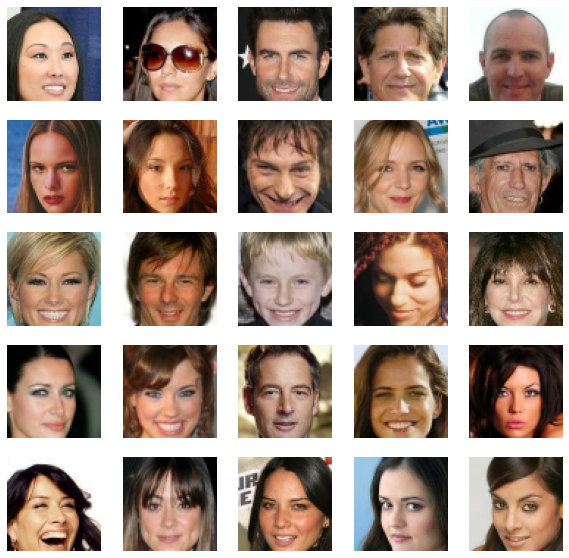

In [0]:
image_batch = next(iter(training_dataset))
show_batch(image_batch["encoder_input"].numpy())

## Network model
Here, we build the network model.

In [0]:
def sampling(args):
  """Samples latent variable from a normal distribution using the given parameters."""
  z_mean, z_log_sigma = args
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
  return z_mean + K.exp(z_log_sigma) * epsilon
  
def create_encoding_block(x, num_filters):
  x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
  x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
  x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D()(x)

  return x

def create_decoding_block(x, num_filters):
  x = UpSampling2D()(x)
  x = Conv2D(num_filters, 3, activation='relu', padding = 'same')(x)
  x = Conv2D(num_filters, 3, activation='relu', padding = 'same')(x)
  x = Conv2D(num_filters, 3, activation='relu', padding = 'same')(x)

  return x

def create_vae():
  # Define encoder model.
  input_img = Input(shape =(64, 64, 3), name='encoder_input')
  conditioning = Input((40,), name='label_input')

  enc_1 = create_encoding_block(input_img, 8)
  enc_2 = create_encoding_block(enc_1, 16)
  enc_3 = create_encoding_block(enc_2, 32)
  enc_4 = create_encoding_block(enc_3, 64)

  _, *shape_spatial = enc_4.get_shape().as_list()

  x = Flatten()(enc_4)

  z_mean = Dense(LATENT_DIM, name='z_mean', activation='relu')(x)
  z_log_var = Dense(LATENT_DIM, name='z_log_var', activation='relu')(x)
  z = Lambda(sampling, output_shape=(LATENT_DIM,))([z_mean, z_log_var])

  zy = Concatenate()([z,conditioning])

  # To get an exact mirror image of the encoder
  inputs_embedding = Input(shape=(LATENT_DIM + 40,))
  embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
  embedding = Reshape(enc_4.shape.as_list()[1:])(embedding)

  dec_3 = create_decoding_block(embedding, 64)
  dec_4 = create_decoding_block(dec_3, 32)
  dec_5 = create_decoding_block(dec_4, 16)
  dec_6 = create_decoding_block(dec_5, 8)
  x_hat = Conv2D(3, 3, activation = 'sigmoid', padding='same')(dec_6)

  encoder = Model(inputs = [input_img, conditioning], outputs = zy, name="encoder")

  decoder = Model(inputs = inputs_embedding, outputs = x_hat, name="decoder")

  vae_out = decoder(encoder([input_img, conditioning]))

  rec_loss =  np.prod(TARGET_IMAGE_SIZE) * tf.keras.losses.mean_squared_error(Flatten()(input_img), Flatten()(vae_out))
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(rec_loss + kl_loss)

  vae = Model(inputs = [input_img, conditioning], outputs = vae_out, name="vae")

  vae.add_loss(vae_loss)

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  vae.compile(optimizer)

  # Add KL divergence regularization loss.
  

  return vae, encoder, decoder

vae, encoder, decoder = create_vae()

vae.summary()
print("\n")
encoder.summary()
print("\n")
decoder.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: label_input:0
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 296)          647488      encoder_input[0][0]              
                                                                 label_input[0][0]                
________________________________________________________________

In [0]:
vae.fit(training_dataset, steps_per_epoch=202599//BATCH_SIZE, verbose = 1, epochs = 10, shuffle = True)

In [0]:
vae.save_weights('vae.h5')
decoder.save_weights('decoder.h5')
encoder.save_weights('encoder.h5')

In [0]:
vae.load_weights('vae.h5')
decoder.load_weights('decoder.h5')
encoder.load_weights('encoder.h5')

In [0]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

def calculate_fid(act1 , act2):
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  ssdiff = np.sum((mu1 - mu2)**2.0)
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

inseption_model = InceptionV3(include_top=False, pooling='avg')

Calculating activations for each batch...
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Done!


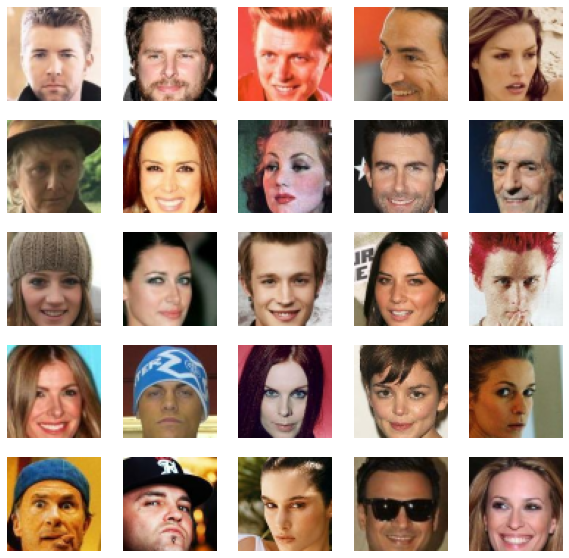

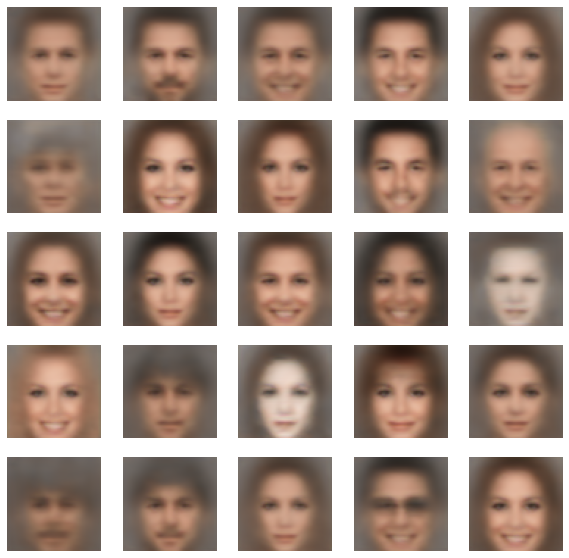

In [0]:
fid_set = training_dataset.unbatch().take(10000).batch(BATCH_SIZE)

print("Calculating activations for each batch...")
img_act = np.array([]).reshape((0, 2048))
pred_act = np.array([]).reshape((0, 2048))
i = 1
for batch in fid_set:
  print("Batch", i)
  images = batch['encoder_input']
  images1 = scale_images(images, (299, 299, 3))
  predictions = vae.predict(batch)
  if i == 1:
    imgs1 = images
    prediction1 = predictions
  images2 = scale_images(predictions, (299, 299, 3))
  a = inseption_model.predict(images1)
  b = inseption_model.predict(images2)
  img_act = np.concatenate((img_act, a), axis = 0)
  pred_act = np.concatenate((pred_act, b), axis = 0)
  i += 1
print("Done!")
show_batch(imgs1)
show_batch(prediction1)

In [0]:
fid_score = calculate_fid(img_act, pred_act)
print("Score for reconstruction:")
print(fid_score)

Score for reconstruction:
188.25451686673756


Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79


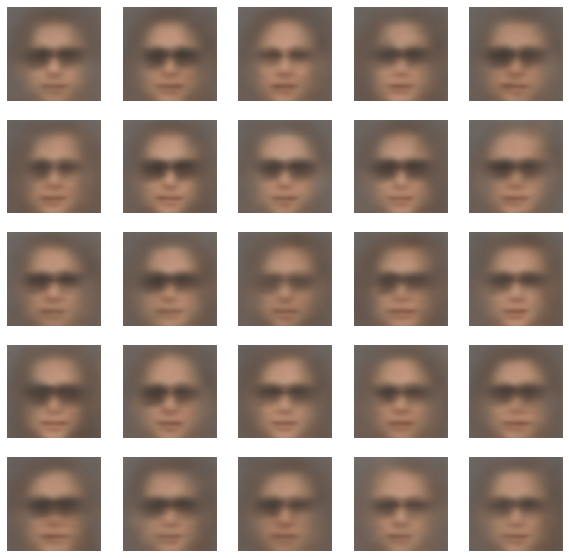

In [0]:
z_sample = np.random.randn(10000, LATENT_DIM).astype("float32")
label = np.zeros(shape=(10000,ATTRIBUTES_SIZE), dtype="float32")
label[:, 15] = 1
z = np.concatenate((z_sample, label), axis=1)

batched = 0
count = 0
pred_act = np.array([]).reshape((0, 2048))
while batched < 10000:
  count += 1
  print("Batch", count)
  z_batch = z[batched: batched + BATCH_SIZE]
  predictions = decoder.predict(z_batch)
  if count == 1:
    prediction1 = predictions
  images2 = scale_images(predictions, (299, 299, 3))
  a = inseption_model.predict(images2)
  pred_act = np.concatenate((pred_act, a), axis = 0)
  batched += BATCH_SIZE

show_batch(prediction1)

In [0]:
fid_score = calculate_fid(img_act, pred_act)
print("Score for generation:")
print(fid_score)

Score for generation:
329.40084381158704


(128, 64, 64, 3)


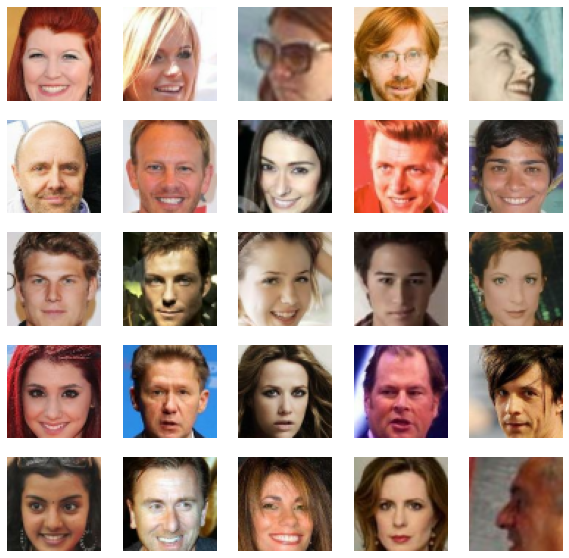

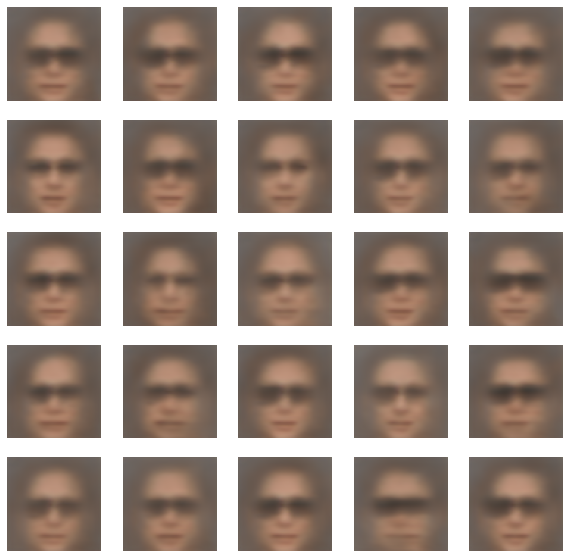

In [0]:
batch = next(iter(training_dataset))
image_batch = batch['encoder_input'].numpy()
show_batch(image_batch)
predictions = vae.predict([image_batch,label[:128]])
show_batch(predictions)